**[MST-1]** モジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

np.random.seed(20160612)
tf.set_random_seed(20160612)

**[MST-2]** MNISTのデータセットを用意します。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


**[MST-3]** 単層ニューラルネットワークを表現するクラスを定義します。

In [3]:
class SingleLayerNetwork:
    def __init__(self, num_units):
        with tf.Graph().as_default():
            self.prepare_model(num_units)
            self.prepare_session()

    def prepare_model(self, num_units):
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, [None, 784], name='input')
        
        with tf.name_scope('hidden'):
            b1 = tf.Variable(tf.zeros([1, num_units]), name='biases')
            w1 = tf.Variable(tf.truncated_normal([784, num_units]),
                             name='weights')        
            hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1, name='hidden1')
        
        with tf.name_scope('output'):
            w0 = tf.Variable(tf.zeros([num_units, 10]), name='weights')
            b0 = tf.Variable(tf.zeros([10]), name='biases')
            p = tf.nn.softmax(tf.matmul(hidden1, w0) + b0, name='softmax')

        with tf.name_scope('optimizer'):
            t = tf.placeholder(tf.float32, [None, 10], name='labels')
            loss = -tf.reduce_sum(t * tf.log(p), name='loss')
            train_step = tf.train.AdamOptimizer().minimize(loss)

        with tf.name_scope('evaluator'):
            correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction,
                                              tf.float32), name='accuracy')

        tf.scalar_summary("loss", loss)
        tf.scalar_summary("accuracy", accuracy)
        tf.histogram_summary("weights_hidden", w1)
        tf.histogram_summary("biases_hidden", b1)
        tf.histogram_summary("weights_output", w0)
        tf.histogram_summary("biases_output", b0)
                
        self.x, self.t, self.p = x, t, p
        self.train_step = train_step
        self.loss = loss
        self.accuracy = accuracy
            
    def prepare_session(self):
        sess = tf.InteractiveSession()
        sess.run(tf.initialize_all_variables())
        summary = tf.merge_all_summaries()
        writer = tf.train.SummaryWriter("/tmp/mnist_sl_logs", sess.graph)
        
        self.sess = sess
        self.summary = summary
        self.writer = writer

**[MST-4]** TensorBoard用のデータ出力ディレクトリーを削除して初期化しておきます。

In [4]:
!rm -rf /tmp/mnist_sl_logs

**[MST-5]** パラメーターの最適化を2000回繰り返します。テストセットに対して、約97%の正解率が得られます。

In [5]:
nn = SingleLayerNetwork(1024)

i = 0
for _ in range(2000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(100)
    nn.sess.run(nn.train_step, feed_dict={nn.x: batch_xs, nn.t: batch_ts})
    if i % 100 == 0:
        summary, loss_val, acc_val = nn.sess.run([nn.summary, nn.loss, nn.accuracy],
            feed_dict={nn.x:mnist.test.images, nn.t: mnist.test.labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))
        nn.writer.add_summary(summary, i)

Step: 100, Loss: 3322.517822, Accuracy: 0.897400
Step: 200, Loss: 2434.060059, Accuracy: 0.926200
Step: 300, Loss: 1768.122559, Accuracy: 0.946700
Step: 400, Loss: 1933.663330, Accuracy: 0.938200
Step: 500, Loss: 1787.954590, Accuracy: 0.943200
Step: 600, Loss: 1448.545288, Accuracy: 0.952900
Step: 700, Loss: 1273.723755, Accuracy: 0.962400
Step: 800, Loss: 1193.774170, Accuracy: 0.963300
Step: 900, Loss: 1167.133667, Accuracy: 0.963900
Step: 1000, Loss: 1262.881104, Accuracy: 0.962100
Step: 1100, Loss: 1078.166626, Accuracy: 0.968000
Step: 1200, Loss: 1080.642822, Accuracy: 0.966900
Step: 1300, Loss: 1160.195312, Accuracy: 0.965000
Step: 1400, Loss: 1052.764160, Accuracy: 0.968600
Step: 1500, Loss: 1048.333862, Accuracy: 0.966400
Step: 1600, Loss: 1059.697388, Accuracy: 0.967500
Step: 1700, Loss: 934.730347, Accuracy: 0.970000
Step: 1800, Loss: 907.469971, Accuracy: 0.972000
Step: 1900, Loss: 904.269531, Accuracy: 0.970900
Step: 2000, Loss: 940.081604, Accuracy: 0.972000


**[MST-6]** 最適化されたパラメーターを用いて、テストセットに対する予測を表示します。

ここでは、「０」〜「９」の数字に対して、正解と不正解の例を３個ずつ表示します。

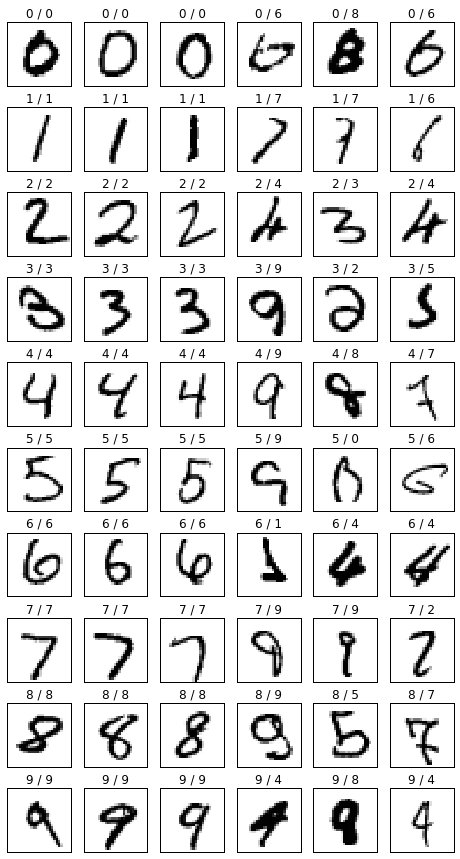

In [6]:
images, labels = mnist.test.images, mnist.test.labels
p_val = nn.sess.run(nn.p, feed_dict={nn.x:images, nn.t: labels}) 

fig = plt.figure(figsize=(8,15))
for i in range(10):
    c = 1
    for (image, label, pred) in zip(images, labels, p_val):
        prediction, actual = np.argmax(pred), np.argmax(label)
        if prediction != i:
            continue
        if (c < 4 and i == actual) or (c >= 4 and i != actual):
            subplot = fig.add_subplot(10,6,i*6+c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_title('%d / %d' % (prediction, actual))
            subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                           cmap=plt.cm.gray_r, interpolation="nearest")
            c += 1
            if c > 6:
                break